## Assignment 2: 

First task for Assignment Part 2 is to code up the teacher model, and use it to generate some data sets of toy sentences for a few different values of the embedding dimensionality 𝐷(e.g., 𝐷=100 and 𝐷 = 1000).
All the hyperparameter settings are initially to be kept the same as in the Cui et al. paper (the same values were also mentioned in class). But try to write your code in a way where these settings can be easily changed later on, to enable future experiments with the same code.
Data generation part at least should be pretty straightforward. After that, the next step should be to get familiar with how to train simple transformer models in PyTorch, so that you can use that to train the student model on the generated data sets. We will discuss the student model further next week.

- Use bash for running code?

### References:
[Cui et al](https://web.iitd.ac.in/~sumeet/Cui_24.pdf)


In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [10]:
import torch
import numpy as np

def generate_word_embeddings(L, D, seed=None):
    """
    Generate word embeddings x_l ~ N(0, 0.25 I_D)
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    # Generate embeddings with std dev = sqrt(0.25) = 0.5
    embeddings = torch.normal(mean=0.0, std=0.5, size=(L, D))
    return embeddings

def positional_component(l, m):
    return 0.6 if l == m else 0.4

def compute_attention_weights(X, W_Q, omega, DK):
    """
    Compute attention weights of teacher model as a mixture of semantic and positional components
    """
    L, D = X.shape

    # Calculate query vectors for each position
    Q = X @ W_Q  # Shape: (L, DK)
    
    # Compute semantic scores: Q_l @ Q_m / sqrt(DK)
    # Shape: (L, L)
    semantic_scores = torch.matmul(Q, Q.transpose(0, 1)) / torch.sqrt(torch.tensor(DK))
    
    # Apply softmax row-wise to get semantic attention
    softmax_semantic = torch.nn.functional.softmax(semantic_scores, dim=1)
    
    # Create positional prior matrix
    positional_scores = torch.zeros((L, L))
    for l in range(L):
        for m in range(L):
            positional_scores[l, m] = positional_component(l, m)
    
    # Mix semantic and positional components
    attention_weights = (1 - omega) * softmax_semantic + omega * positional_scores
    
    return attention_weights

def generate_single_datapoint(D, L, DK, omega, W_Q, seed=None):
    """
    Generate a single datapoint (X, T)
    """
    X = generate_word_embeddings(L, D, seed)
    print("Xshape",X.shape)
    A = compute_attention_weights(X, W_Q, omega, DK)
    print("Ashape",A.shape)
    T = torch.matmul(A, X)
    return X, T

def generate_teacher_dataset(N, D=100, L=2, DK=1, omega=0.3, seed=None):
    """
    Generate a teacher dataset of size N
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    # Generate shared query weight matrix
    W_Q = torch.normal(mean=0.0, std=1.0, size=(D, DK))
    
    X_all = torch.zeros((N, L, D))
    T_all = torch.zeros((N, L, D))
    
    for n in range(N):
        # Use a different seed for each datapoint
        datapoint_seed = seed + n if seed is not None else None
        X, T = generate_single_datapoint(D, L, DK, omega, W_Q, datapoint_seed)
        X_all[n] = X
        T_all[n] = T
    
    return X_all, T_all, W_Q


# Set parameters
L = 2                # Number of words per sentence
D = 1000              # Dimensionality of embedding vectors
N = int(2.2 * D)     # Dataset size
N = 1
DK = 1               # Dimensionality of key/query vectors
omega = 0.3          # Mixture weight for positional component
seed = 42            # Random seed


# Generate teacher dataset
X_teacher, T_teacher, W_Q_teacher = generate_teacher_dataset(
    N=N, D=D, L=L, DK=DK, omega=omega, seed=seed
)

print(f"X_teacher shape: {X_teacher.shape}")
print(f"T_teacher shape: {T_teacher.shape}")
print(f"W_Q_teacher shape: {W_Q_teacher.shape}")

Xshape torch.Size([2, 1000])
Ashape torch.Size([2, 2])
X_teacher shape: torch.Size([1, 2, 1000])
T_teacher shape: torch.Size([1, 2, 1000])
W_Q_teacher shape: torch.Size([1000, 1])


alpha =  0.2
alpha =  0.4
alpha =  0.6000000000000001
alpha =  0.8
alpha =  1.0
alpha =  1.2000000000000002
alpha =  1.4000000000000001
alpha =  1.6
alpha =  1.8
alpha =  2.0
alpha =  0.2
alpha =  0.4
alpha =  0.6000000000000001
alpha =  0.8
alpha =  1.0
alpha =  1.2000000000000002
alpha =  1.4000000000000001
alpha =  1.6
alpha =  1.8
alpha =  2.0

Initialization: semantic
Alpha    Train MSE    Test MSE
0.2      0.089809      0.087976
0.4      0.079345      0.079222
0.6      0.079209      0.079222
0.8      0.079314      0.079222
1.0      0.079392      0.079222
1.2      0.088408      0.088117
1.4      0.079450      0.079716
1.6      0.081088      0.082053
1.8      0.079406      0.079222
2.0      0.090555      0.090103

Initialization: positional
Alpha    Train MSE    Test MSE
0.2      0.079341      0.079222
0.4      0.079345      0.079222
0.6      0.079209      0.079222
0.8      0.079314      0.079222
1.0      0.079392      0.079222
1.2      0.079318      0.079222
1.4      0.079334     

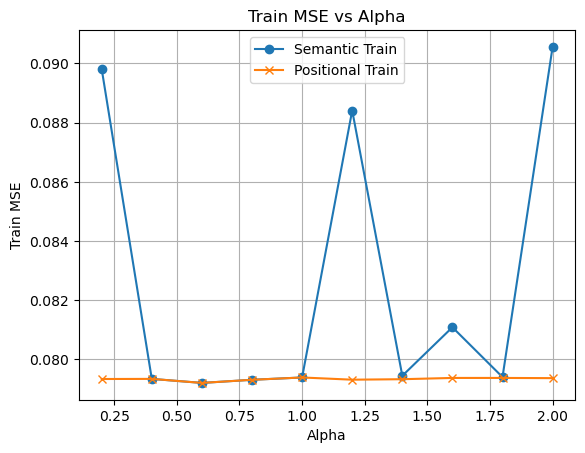

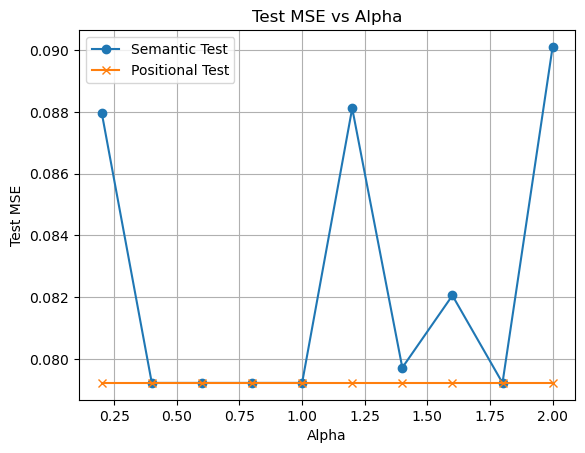

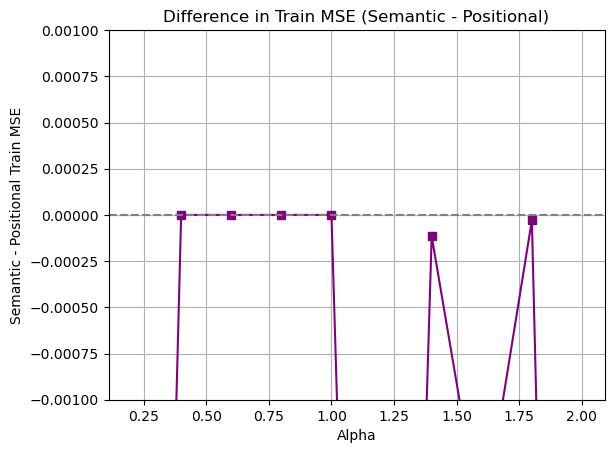

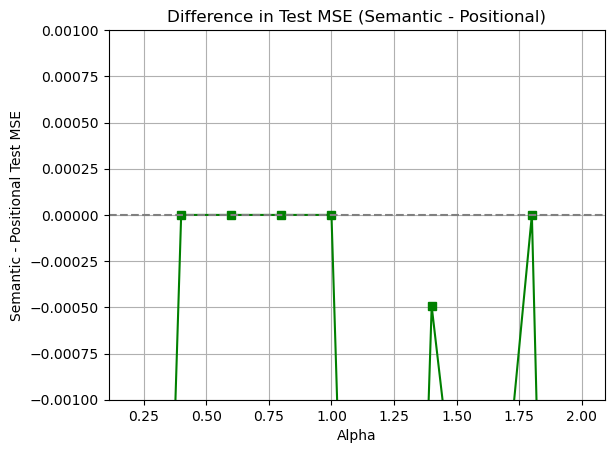

In [9]:
import torch
import torch.nn as nn
from typing import Optional, Tuple, List, Dict
import matplotlib.pyplot as plt

class StudentModel(nn.Module):
    """
    Student model that learns attention-based mappings with simple positional embeddings for L=2.

    Initialization options:
      - 'random': W_Q ~ N(0, 0.01)
      - 'semantic': W_Q = W_Q_teacher (requires W_Q_init)
      - 'positional': W_Q^T = identity (r1) for first DK rows
    """
    def __init__(self,
                 D: int,
                 DK: int,
                 init: str = 'random',
                 W_Q_init: Optional[torch.Tensor] = None):
        super().__init__()
        self.D = D
        self.DK = DK

        # Initialize W_Q
        if init == 'semantic':
            if W_Q_init is None:
                raise ValueError("W_Q_init must be provided for semantic initialization.")
            self.W_Q = nn.Parameter(W_Q_init.clone().to(torch.get_default_dtype()))
        elif init == 'positional':
            self.W_Q = torch.nn.Parameter(torch.ones(D).reshape(-1, 1)/np.sqrt(D))
        else:
            self.W_Q = nn.Parameter(torch.randn(D, DK) * 0.01)

        # Positional embeddings: +1 for first token, -1 for second
        pos = torch.stack([torch.ones(D), -torch.ones(D)], dim=0)
        self.register_buffer('pos_embed', pos)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Add positional information
        X_tilde = X + self.pos_embed.unsqueeze(0)
        # Project to queries
        Q = X_tilde @ self.W_Q
        # Scaled dot-product attention
        scale = torch.sqrt(torch.tensor(self.DK, dtype=X.dtype, device=X.device))
        scores = (Q @ Q.transpose(-1, -2)) / scale
        attn = torch.softmax(scores, dim=-1)
        # Weighted sum
        Y = attn @ X
        return Y


def compute_loss(
    Y: torch.Tensor,
    T: torch.Tensor,
    W_Q: nn.Parameter,
    l2_lambda: float
) -> torch.Tensor:
    _, _, D = Y.shape
    sse = torch.sum((Y - T) ** 2)
    scaled_sse = sse / (2 * D)
    l2 = (l2_lambda / 2) * torch.sum(W_Q ** 2)
    return scaled_sse + l2

def mse(Y: torch.Tensor, T: torch.Tensor) -> float:
    return torch.mean((Y - T) ** 2).item()


def train_student_fullbatch(
    X: torch.Tensor,
    T: torch.Tensor,
    D: int,
    DK: int,
    init: str = 'random',
    W_Q_init: Optional[torch.Tensor] = None,
    epochs: int = 100,
    lr: float = 1e-3,
    l2_lambda: float = 1e-2,
    device: Optional[torch.device] = None
) -> Tuple[StudentModel, List[float]]:
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model = StudentModel(D, DK, init=init, W_Q_init=W_Q_init).to(device)
    X, T = X.to(device), T.to(device)
    history: List[float] = []
    for epoch in range(1, epochs + 1):
        Y = model(X)
        loss = compute_loss(Y, T, model.W_Q, l2_lambda)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            model.W_Q -= lr * model.W_Q.grad
        history.append(loss.item())
    return model, history


def run_experiments(
    D: int,
    DK: int,
    omega: float,
    seed: int,
    init: str,
    alphas: List[float],
    epochs: int,
    lr: float,
    l2_lambda: float,
    device: Optional[torch.device] = None
) -> Tuple[Dict[float, float], Dict[float, float]]:
    # Generate teacher data
    N = int(2.2 * D)
    X_all, T_all, W_Q_teacher = generate_teacher_dataset(
        N=N, D=D, L=2, DK=DK, omega=omega, seed=seed
    )

    # Split train/test: last 0.2D for test
    test_size = int(0.2 * D)
    X_train, X_test = X_all[:-test_size], X_all[-test_size:]
    T_train, T_test = T_all[:-test_size], T_all[-test_size:]

    train_errors: Dict[float, float] = {}
    test_errors: Dict[float, float] = {}

    for alpha in alphas:
        print("alpha = ",alpha)
        n_train = int(alpha * D)
        X_sub, T_sub = X_train[:n_train], T_train[:n_train]
        WQ_init = W_Q_teacher if init == 'semantic' else None
        model, history = train_student_fullbatch(
            X_sub, T_sub, D, DK,
            init=init, W_Q_init=WQ_init,
            epochs=epochs, lr=lr, l2_lambda=l2_lambda,
            device=device
        )
        # Training MSE
        model.eval()
        with torch.no_grad():
            Y_train = model(X_sub.to(device))
            train_errors[alpha] = mse(Y_train, T_sub.to(device))

            Y_test = model(X_test.to(device))
            test_errors[alpha] = mse(Y_test, T_test.to(device))

    return train_errors, test_errors

if __name__ == '__main__':
    # Experiment settings
    D, DK = 1000, 1
    omega = 0.99
    seed = 42
    alphas = [0.2 * i for i in range(1, 11)]  # 0.2, 0.4, ..., 2.0
    epochs = 1
    lr = 0.15
    l2_lambda = 1e-2

    results = {}
    for init_choice in ['semantic', 'positional']:
        train_err, test_err = run_experiments(
            D, DK, omega, seed,
            init_choice, alphas,
            epochs, lr, l2_lambda
        )
        results[init_choice] = (train_err, test_err)

    # Print results
    for init_choice, (train_err, test_err) in results.items():
        print(f"\nInitialization: {init_choice}")
        print("Alpha    Train MSE    Test MSE")
        for alpha in alphas:
            print(f"{alpha:.1f}      {train_err[alpha]:.6f}      {test_err[alpha]:.6f}")

    # Extract for plotting
    semantic_train = results['semantic'][0]
    semantic_test = results['semantic'][1]
    positional_train = results['positional'][0]
    positional_test = results['positional'][1]

    train_diff = [positional_train[a]-semantic_train[a]  for a in alphas]
    test_diff = [positional_test[a] - semantic_test[a] for a in alphas]

    # Plot Train Errors
    plt.figure()
    plt.plot(alphas, [semantic_train[a] for a in alphas], marker='o', label='Semantic Train')
    plt.plot(alphas, [positional_train[a] for a in alphas], marker='x', label='Positional Train')
    plt.xlabel('Alpha')
    plt.ylabel('Train MSE')
    plt.title('Train MSE vs Alpha')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Test Errors
    plt.figure()
    plt.plot(alphas, [semantic_test[a] for a in alphas], marker='o', label='Semantic Test')
    plt.plot(alphas, [positional_test[a] for a in alphas], marker='x', label='Positional Test')
    plt.xlabel('Alpha')
    plt.ylabel('Test MSE')
    plt.title('Test MSE vs Alpha')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Difference in Train MSE
    plt.figure()
    plt.plot(alphas, train_diff, marker='s', color='purple')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Alpha')
    plt.ylabel('Semantic - Positional Train MSE')
    plt.title('Difference in Train MSE (Semantic - Positional)')
    plt.grid(True)
    plt.ylim(-1e-3,1e-3)
    
    plt.show()

    # Plot Difference in Test MSE
    plt.figure()
    plt.plot(alphas, test_diff, marker='s', color='green')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Alpha')
    plt.ylabel('Semantic - Positional Test MSE')
    plt.title('Difference in Test MSE (Semantic - Positional)')
    plt.grid(True)
    plt.ylim(-1e-3,1e-3)
    plt.show()

In [4]:
# implement dense model
# Plotting scripts

In [5]:
# Plot generation